# Dirichlet mixtures of multinomials

TODO: Update by "trying to adopt the point of view of a user who thinks this model is what she needs but is not sure yet" as suggested by @AlexAndorra

TODO: Explain purpose of topic modeling, bag-of-words data, cite [@Blei2003]

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import scipy.stats
import seaborn as sns
import theano.tensor as tt
import xarray as xr

In [2]:
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# TODO: Drop this:
plt.rcParams[
    "figure.dpi"
] = 60  # Less than the default so it's easier to see figures with their code.

## Simulation data

TODO:
- Introduce the example, data and parameters.
- What's this type of model?
- In which contexts can it be useful?
- What are its strenghts and weaknesses?

In [3]:
conc = 3.0
frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
k = len(frac)
n_samples = 10
total_count = 50

y = pm.DirichletMultinomial.dist(a=frac * conc, n=total_count, shape=(n_samples, k)).random()
y

# FIXME: Why does this fail so frequently??
# p = sp.stats.dirichlet(conc * frac).rvs(size=n_samples).astype('float64')
# y = np.stack([sp.stats.multinomial(n=20, p=p[i, :]).rvs()[0] for i in range(n_samples)])

array([[36.,  5.,  3.,  6.,  0.],
       [36., 13.,  1.,  0.,  0.],
       [29.,  7., 14.,  0.,  0.],
       [17.,  0.,  8., 25.,  0.],
       [24., 25.,  1.,  0.,  0.],
       [32.,  8.,  8.,  2.,  0.],
       [25., 25.,  0.,  0.,  0.],
       [28., 21.,  1.,  0.,  0.],
       [22.,  4.,  0., 24.,  0.],
       [16.,  7., 21.,  6.,  0.]])

## Null multinomial model

TODO:
- What's the model doing?
- What do the parameters mean?
- How are you choosing the priors?
- Why are you parametrizing the Dirichlet with a * alpha instead of the classical alpha?
- Are you expecting this model to run well?

In [4]:
with pm.Model() as model_null:
    a = pm.Dirichlet("a", a=np.ones(k))
    obs = pm.Multinomial("obs", n=total_count, p=a, shape=(n_samples, k), observed=y)

    trace_null = pm.sample(
        draws=int(5e3), chains=4, step=pm.Metropolis(), return_inferencedata=True
    )

Multiprocess sampling (4 chains in 2 jobs)
Metropolis: [a]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 23 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


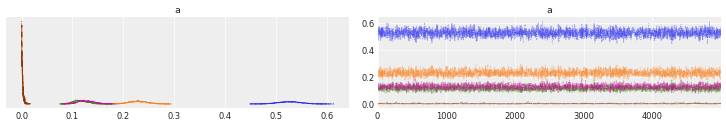

In [5]:
az.plot_trace(data=trace_null, var_names=["a"], compact=True)
None

In [6]:
summary_null = az.summary(trace_null, var_names=["a"])
summary_null = summary_null.assign(
    ess_mean_per_sec=lambda x: x.ess_mean / trace_null.posterior.sampling_time,
)
# assert all(summary_null.r_hat < 1.03)

summary_null

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
a[0],0.526,0.022,0.485,0.567,0.0,0.0,2224.0,2224.0,2220.0,2574.0,1.00,98.285250
a[1],0.229,0.019,0.193,0.262,0.0,0.0,1876.0,1876.0,1878.0,2521.0,1.00,82.906083
a[2],0.115,0.014,0.090,0.142,0.0,0.0,1400.0,1398.0,1423.0,2135.0,1.00,61.870211
a[3],0.127,0.015,0.099,0.154,0.0,0.0,1386.0,1386.0,1388.0,2056.0,1.00,61.251509
a[4],0.002,0.002,0.000,0.006,0.0,0.0,180.0,180.0,130.0,167.0,1.03,7.954741


In [7]:
with model_null:
    ppc = pm.fast_sample_posterior_predictive(
        trace=trace_null,
        keep_size=True,
    )

# Concatenate with InferenceData object
trace_null.extend(az.from_dict(posterior_predictive=ppc))

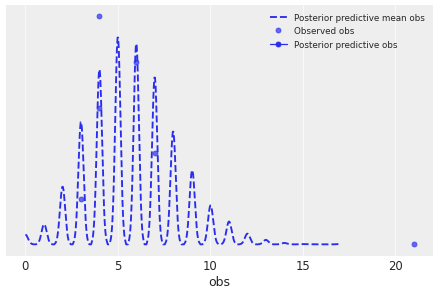

In [8]:
# TODO: Is there an invocation of plot_ppc that demonstrates the
# overdispersion of observations relative to the multinomial?
# If nothing is better than the manually constructed plot below, drop this cell.

az.plot_ppc(
    trace_null,
    kind="scatter",
    var_names=["obs"],
    coords=dict(obs_dim_0=[9], obs_dim_1=[2]),
)
None

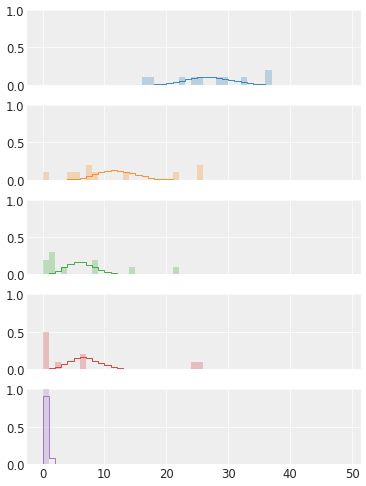

In [9]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(k, 1, sharex=True, sharey=True, figsize=(6, 8))
for j, ax in enumerate(axs.flatten()):
    c = cmap(j)
    ax.hist(
        trace_null.posterior_predictive.obs[:, :, :, j].values.flatten(),
        bins=np.arange(total_count),
        histtype="step",
        color=c,
        density=True,
    )
    ax.hist(
        trace_null.observed_data.obs[:, j].values.flatten(),
        bins=np.arange(total_count),
        color=c,
        density=True,
        alpha=0.25,
    )
ax.set_ylim(0, 1)
None

TODO:
- How satisfied are you with these diagnostics and trace plot?
- How does it motivate the use of the coming mixture model?

## Explicit Model

In [10]:
with pm.Model() as model_explicit:
    a = pm.Dirichlet("a", a=np.ones(k))
    alpha = pm.Lognormal("alpha", mu=1, sigma=1)
    pi = pm.Dirichlet("pi", a=a * alpha, shape=(n_samples, k))
    obs = pm.Multinomial("obs", n=total_count, p=pi, shape=(n_samples, k), observed=y)

    trace_explicit = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [pi, alpha, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 264 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46141580088641754, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6956159363750734, but should be close to 0.8. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


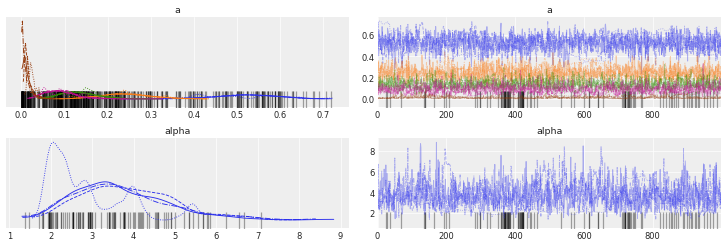

In [11]:
az.plot_trace(data=trace_explicit, var_names=["a", "alpha"], compact=True)
None

In [12]:
summary_explicit = az.summary(trace_explicit, var_names=["a", "alpha"])
summary_explicit = summary_explicit.assign(
    ess_mean_per_sec=lambda x: x.ess_mean / trace_explicit.posterior.sampling_time,
)
# assert all(summary_explicit.r_hat < 1.03)

summary_explicit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
a[0],0.518,0.078,0.377,0.660,0.008,0.006,97.0,97.0,99.0,142.0,1.05,0.367946
a[1],0.241,0.057,0.130,0.347,0.005,0.004,120.0,120.0,120.0,84.0,1.01,0.455192
a[2],0.136,0.040,0.063,0.208,0.003,0.002,188.0,188.0,189.0,465.0,1.01,0.713133
a[3],0.090,0.035,0.035,0.155,0.003,0.002,111.0,111.0,106.0,388.0,1.04,0.421052
a[4],0.015,0.011,0.001,0.036,0.003,0.002,15.0,15.0,13.0,43.0,1.24,0.056899
alpha,3.546,1.184,1.785,5.677,0.172,0.122,48.0,48.0,36.0,118.0,1.08,0.182077


TODO:
- How satisfied are you with these diagnostics and trace plot?
- How does it motivate the use of the coming mixture model?

## Marginalized model

In [13]:
with pm.Model() as model_marginalized:
    a = pm.Dirichlet("a", a=np.ones(k))
    alpha = pm.Lognormal("alpha", mu=1, sigma=1)
    obs = pm.DirichletMultinomial(
        "obs", n=total_count, a=a * alpha, shape=(n_samples, k), observed=y
    )

    trace_marginalized = pm.sample(chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [alpha, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


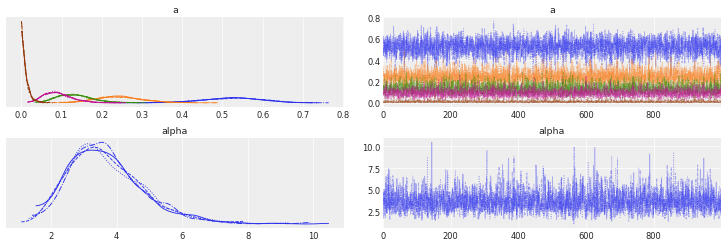

In [14]:
az.plot_trace(data=trace_marginalized, var_names=["a", "alpha"], compact=True)
None

In [15]:
summary_marginalized = az.summary(trace_marginalized, var_names=["a", "alpha"])
summary_marginalized = summary_marginalized.assign(
    ess_mean_per_sec=lambda x: x.ess_mean / trace_marginalized.posterior.sampling_time,
)
assert all(summary_marginalized.r_hat < 1.03)

summary_marginalized

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
a[0],0.524,0.072,0.389,0.655,0.001,0.001,4202.0,4202.0,4277.0,3208.0,1.0,123.008917
a[1],0.243,0.057,0.141,0.354,0.001,0.001,5967.0,5600.0,5982.0,3310.0,1.0,174.677345
a[2],0.133,0.043,0.058,0.213,0.001,0.000,4415.0,4357.0,4268.0,2810.0,1.0,129.244257
a[3],0.091,0.034,0.033,0.158,0.001,0.000,4082.0,3995.0,3975.0,2655.0,1.0,119.496049
a[4],0.010,0.010,0.000,0.027,0.000,0.000,2791.0,2791.0,1774.0,979.0,1.0,81.703447
alpha,3.686,1.160,1.662,5.769,0.020,0.014,3337.0,3243.0,3313.0,3041.0,1.0,97.686995


TODO:
- How satisfied are you with these diagnostics and trace plot?

In [16]:
with model_marginalized:
    ppc = pm.fast_sample_posterior_predictive(trace_marginalized, keep_size=True)

# Concatenate with InferenceData object
trace_marginalized.extend(az.from_dict(posterior_predictive=ppc))

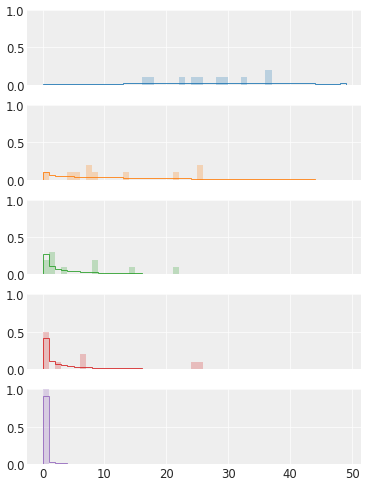

In [17]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(k, 1, sharex=True, sharey=True, figsize=(6, 8))
for j, ax in enumerate(axs.flatten()):
    c = cmap(j)
    ax.hist(
        trace_marginalized.posterior_predictive.obs[:, :, :, j].values.flatten(),
        bins=np.arange(total_count),
        histtype="step",
        color=c,
        density=True,
    )
    ax.hist(
        trace_marginalized.observed_data.obs[:, j].values.flatten(),
        bins=np.arange(total_count),
        color=c,
        density=True,
        alpha=0.25,
    )
ax.set_ylim(0, 1)
None

TODO:
- How does this model solve the problem you were having above?

## Model Comparison

In [18]:
az.compare({"multinomial": trace_null, "dirichlet_multinomial": trace_marginalized}, ic="loo")

/Users/byronsmith/anaconda3/envs/pymc3-dev/lib/python3.9/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/byronsmith/anaconda3/envs/pymc3-dev/lib/python3.9/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
dirichlet_multinomial,0,-90.753415,3.689915,0.000000,1.0,25.564354,0.000000,False,log
multinomial,1,-203.518988,29.883029,112.765573,0.0,5.416980,24.841589,True,log


TODO:
- What does the LOO model comparison show?
- What do we conclude?

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 18 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.19.0

numpy     : 1.19.4
arviz     : 0.10.0
matplotlib: 3.3.3
pymc3     : 3.10.0
xarray    : 0.16.2
pandas    : 1.2.0
json      : 2.0.9
scipy     : 1.6.0
seaborn   : 0.11.1
theano    : 1.0.14

Watermark: 2.1.0

